In [189]:
import random
import numpy as np
import sys
import pandas as pd

In [190]:
constants = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    "TARGET_GAS_USED": 10000000,
    "MAX_GAS_EIP1559": 20000000,
    "EIP1559_DECAY_RANGE": 800000,
    "EIP1559_GAS_INCREMENT_AMOUNT": 10,
    "INITIAL_BASEFEE": 1 * (10 ** 9),
    "PER_TX_GASLIMIT": 8000000,
    "SIMPLE_TRANSACTION_GAS": 21000,
}

In [209]:
# All users want to fit a single 21k gas tx
# If they have to wait 10 blocks and pay 5 Gwei / gas
# the total fee is 105k Gwei
# Value must be >= 105k for payoff to be ever positive
# For our User class, value == value per gwei

rng = np.random.default_rng()

def get_basefee_bounds(basefee, blocks):
    lb = basefee * (1 - 1.0 / constants["BASEFEE_MAX_CHANGE_DENOMINATOR"])
    ub = basefee * (1 + 1.0 / constants["BASEFEE_MAX_CHANGE_DENOMINATOR"])
    return { "lb": lb, "ub": ub }

class Transaction:
    
    def __init__(self, sender, gas_premium, maxfee, start_block, gas_used = constants["SIMPLE_TRANSACTION_GAS"]):
        self.sender = sender
        self.gas_premium = gas_premium
        self.maxfee = maxfee
        self.start_block = start_block
        self.gas_used = gas_used
        self.tx_hash = rng.bytes(8)
        
    def __str__(self):
        return f"Transaction {self.tx_hash.hex()}: maxfee {self.maxfee}, gas_premium {self.gas_premium}"
    
    def is_valid(self, basefee):
        return self.maxfee >= basefee
    
    def gas_price(self, basefee):
        return min(self.maxfee, basefee + self.gas_premium)
    
    def tip(self, basefee):
        return self.gas_price(basefee) - basefee

class Block:
    
    def __init__(self, txs, parent_hash, basefee, height):
        self.txs = txs
        self.block_hash = rng.bytes(8)
        self.parent_hash = parent_hash
        self.basefee = basefee
        self.height = height
        
    def __str__(self):
        return "Block:\n" + "\n".join([tx.__str__() for tx in self.txs])
    
    def average_tip(self): # in Gwei
        return 0 if len(self.txs) == 0 else sum([tx.tip(self.basefee) for tx in self.txs]) / len(self.txs) / (10 ** 9)

    def average_gas_price(self): # in Gwei
        return 0 if len(self.txs) == 0 else sum([tx.gas_price(self.basefee) for tx in self.txs]) / len(self.txs) / (10 ** 9)
    
    def average_waiting_time(self):
        return 0 if len(self.txs) == 0 else sum([self.height - tx.start_block for tx in self.txs]) / len(self.txs)

class Chain:
    
    def __init__(self):
        self.blocks = {}
        self.current_head = (0).to_bytes(8, sys.byteorder)
        
    def add_block(self, block):
        self.blocks[block.block_hash] = block
        self.current_head = block.block_hash
    
class User:
    
    def __init__(self, wakeup_block):
        self.pub_key = rng.bytes(8)
        self.wakeup_block = wakeup_block
        self.value = int(rng.uniform(low = 0, high = 20) * (10 ** 9))
        
    def gas_price(self, basefee):
        tx_parameters = self.decide_parameters()
        return min(tx_parameters["maxfee"], basefee + tx_parameters["gas_premium"])
    
    def transact(self):
        params = self.decide_parameters()
        tx = Transaction(
            sender = self.pub_key,
            gas_premium = params["gas_premium"],
            maxfee = params["maxfee"], 
            start_block = self.wakeup_block,
        )
        return tx
    
class AffineUser(User):
    
    def __init__(self, wakeup_block):
        super().__init__(wakeup_block)
        self.cost_per_unit = int(rng.uniform(low = 0, high = 1) * (10 ** 9))
    
    def decide_parameters(self):
        return {
            "maxfee": self.value - self.expected_time() * self.cost_per_unit,
            "gas_premium": 2 * (10 ** 9),
        }
    
    def expected_time(self):
        return 5
    
    def worst_expected_basefee(self, current_basefee):
        basefee_bounds = get_basefee_bounds(current_basefee, self.expected_time())
        return basefee_bounds["ub"]
    
    def transact(self, basefee):
        params = self.decide_parameters()
        expected_block = self.wakeup_block + self.expected_time()
        payoff = self.payoff(expected_block, self.worst_expected_basefee(basefee))

        if payoff < 0 or params["maxfee"] - params["gas_premium"] < 0:
            return None
        else:
            return super().transact()
    
    def payoff(self, included_block, basefee):
        tx_parameters = self.decide_parameters()
        return self.value - self.cost_per_unit * (included_block - self.wakeup_block) - self.gas_price(basefee)
    
    def __str__(self):
        return f"Affine User with value {self.value} and cost {self.cost_per_unit}"
    
class DiscountUser(User):
        
    def __init__(self, wakeup_block):
        super().__init__(wakeup_block)
        self.discount_rate = 0.01
    
    def decide_parameters(self):
        return {
            "maxfee": self.value * (1 - self.discount_rate) ** self.expected_time(),
            "gas_premium": 2,
        }
    
    def payoff(self, included_block, basefee):
        tx_parameters = self.decide_parameters()
        return self.value * (1 - self.discount_rate) ** (included_block - self.wakeup_block) - self.gas_price(basefee)
    
    def __str__(self):
        return f"Discount User with value {self.value} and discount rate {self.discount_rate}"

class TxPool:
    
    def __init__(self):
        self.txs = {}
        self.pool_length = 0
    
    def add_txs(self, txs):
        for tx in txs:
            self.txs[tx.tx_hash] = tx
        self.pool_length += len(txs)
            
    def remove_txs(self, tx_hashes):
        for tx_hash in tx_hashes:
            del(self.txs[tx_hash])
        self.pool_length -= len(tx_hashes)
            
    def average_tip(self, basefee): # in Gwei
        return 0 if self.pool_length == 0 else sum([tx.tip(basefee) for tx in self.txs.values()]) / self.pool_length / (10 ** 9)
    
    def __str__(self):
        return "\n".join([tx.__str__() for tx in self.txs.values()])
    
def spawn_demand(timestep, demand_lambda):
    real = rng.poisson(demand_lambda)
    new_users = [AffineUser(timestep) for i in range(real)]
    return new_users

def decide_transactions(demand, basefee = 1):
    # User side
    txs = []
    for user in demand:
        tx = user.transact(basefee)
        if not tx is None:
            txs.append(tx)
    return txs

def select_transactions(txpool, basefee = 1):
    # Miner side
    max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])
    sorted_valid_demand = sorted([tx for tx in txpool.txs.values() if tx.is_valid(basefee)], key = lambda tx: -tx.tip(basefee))
    selected_txs = sorted_valid_demand[0:max_tx_in_block]
    return selected_txs

def update_basefee(block, basefee):
    gas_used = sum([tx.gas_used for tx in block.txs])
    delta = gas_used - constants["TARGET_GAS_USED"]
    return basefee + basefee * delta // constants["TARGET_GAS_USED"] // constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]

In [216]:
txpool = TxPool()
basefee = constants["INITIAL_BASEFEE"]
chain = Chain()
metrics = []

for t in range(1000):
    print(t)
    users = spawn_demand(t, 1000)
    decided_txs = decide_transactions(users, basefee)
    txpool.add_txs(decided_txs)
    selected_txs = select_transactions(txpool, basefee)
    block = Block(txs = selected_txs, parent_hash = chain.current_head, basefee = basefee, height = t)
    txpool.remove_txs([tx.tx_hash for tx in selected_txs])
    chain.add_block(block)
    
    row_metrics = {
        "timestep": t,
        "basefee": basefee / (10 ** 9),
        "users": len(users),
        "decided_txs": len(decided_txs),
        "included_txs": len(selected_txs),
        "blk_avg_gas_price": block.average_gas_price(),
        "blk_avg_tip": block.average_tip(),
        "blk_avg_waiting_time": block.average_waiting_time(),
        "pool_length": txpool.pool_length,
        "pool_avg_tip": txpool.average_tip(basefee),
    }
    metrics.append(row_metrics)
    
    basefee = update_basefee(block, basefee)
    
df = pd.DataFrame(metrics)

In [217]:
df

,timestep,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,blk_avg_waiting_time,pool_length,pool_avg_tip
0,0,1.000000,1009,802,802,2.962128,1.962128,0.000000,0,0.000000
1,1,1.085525,978,754,754,3.057114,1.971589,0.000000,0,0.000000
2,2,1.164687,1045,810,810,3.125710,1.961023,0.000000,0,0.000000
3,3,1.266743,1027,774,774,3.210984,1.944242,0.000000,0,0.000000
4,4,1.365770,1015,805,805,3.307407,1.941637,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
995,995,8.149842,963,720,440,9.879923,1.730081,0.025000,289165,-3.189347
996,996,8.072418,980,748,641,9.409481,1.337063,12.823713,289272,-3.113570
997,997,8.421651,1034,778,477,10.175235,1.753584,0.000000,289573,-3.462659
998,998,8.423441,976,743,436,10.202139,1.778699,0.000000,289880,-3.464279


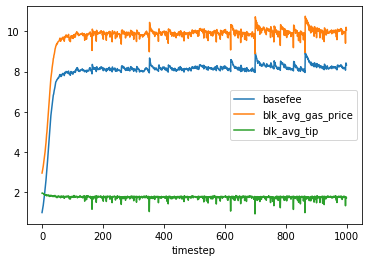

In [218]:
df.plot("timestep", ["basefee", "blk_avg_gas_price", "blk_avg_tip"])

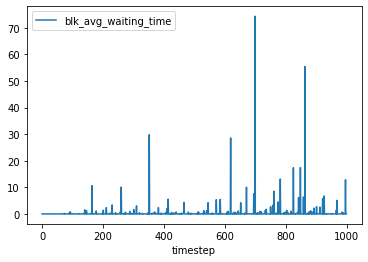

In [219]:
df.plot("timestep", "blk_avg_waiting_time")

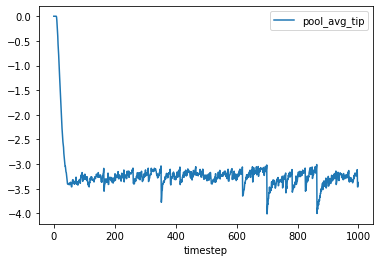

In [220]:
df.plot("timestep", "pool_avg_tip")

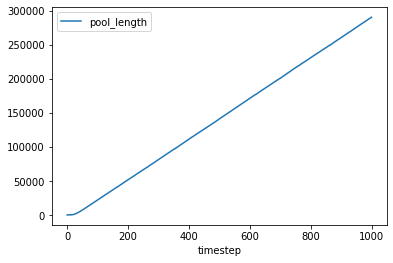

In [221]:
df.plot("timestep", "pool_length")